# Data upload

In [1]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gzip
import Preprocessing as pproc 
import HerdingFunctions as hf
import statsmodels.api as sm

directory = os.getcwd()
data_path = os.path.join(directory, 'Data')

# Definining the path for the files
RB_path = os.path.join(data_path, 'RateBeer')
BA_path = os.path.join(data_path, 'BeerAdvocate')
MB_path = os.path.join(data_path, 'matched_beer_data')

# Extraction of the data and preprocessing of the files

In [2]:
# Extraction of the .tar files
pproc.extract_tar_files(data_path)

In [2]:
#Transformation of the .txt files
pproc.text_to_csv(RB_path, 'ratings')
pproc.text_to_csv(RB_path, 'reviews')

pproc.text_to_csv(BA_path, 'ratings')
pproc.text_to_csv(BA_path, 'reviews')

pproc.text_to_csv(MB_path, 'ratings_ba')
pproc.text_to_csv(MB_path, 'ratings_with_text_ba')
pproc.text_to_csv(MB_path, 'ratings_rb')
pproc.text_to_csv(MB_path, 'ratings_with_text_rb')

# Creation of dataframes

Matching data:

In [3]:
MB_beers = pd.read_csv(MB_path + '/beers.csv', header=1)
MB_breweries = pd.read_csv(MB_path + '/breweries.csv', header=1)
MB_users = pd.read_csv(MB_path + '/users.csv', header=1)
MB_users_approx = pd.read_csv(MB_path + '/users_approx.csv', header=1)

In [4]:
MB_ratings = pd.read_csv(MB_path + '/ratings.csv', header=1)
MB_ratingsBA = pd.read_csv(MB_path + '/ratings_ba.tsv', sep='\t')
MB_ratingsBA_txt = pd.read_csv(MB_path + '/ratings_with_text_ba.tsv', sep='\t')
MB_ratingsRB = pd.read_csv(MB_path + '/ratings_rb.tsv', sep='\t')
MB_ratingsRB_txt = pd.read_csv(MB_path + '/ratings_with_text_rb.tsv', sep='\t')

Rest of the data:

In [4]:
RB_beers = pd.read_csv(RB_path + '/beers.csv')
RB_breweries = pd.read_csv(RB_path + '/breweries.csv')
RB_users = pd.read_csv(RB_path + '/users.csv')
RB_ratings = pd.read_csv(RB_path + '/ratings.tsv', sep='\t')
RB_reviews = pd.read_csv(RB_path + '/reviews.tsv', sep='\t')

In [5]:
BA_beers = pd.read_csv(BA_path + '/beers.csv')
BA_breweries = pd.read_csv(BA_path + '/breweries.csv')
BA_users = pd.read_csv(BA_path + '/users.csv')
BA_ratings = pd.read_csv(BA_path + '/ratings.tsv', sep='\t')
BA_reviews = pd.read_csv(BA_path + '/reviews.tsv', sep='\t')

In [6]:
BA_ratings

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,1440064800,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1235127600,StJamesGate,stjamesgate.163714,3.00,3.50,3.50,4.00,3.5,3.67,Pours pale copper with a thin head that quick...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1142247600,mdagnew,mdagnew.19527,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1101898800,helloloser12345,helloloser12345.10867,4.00,3.50,4.00,4.00,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,1093860000,cypressbob,cypressbob.3708,4.00,4.00,4.00,4.00,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8393027,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1141038000,jaluria,jaluria.31362,3.50,3.50,3.50,4.00,4.0,3.80,I'll start off reviewing this beer with the f...,True
8393028,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1140346800,Dithyramb,dithyramb.4413,3.00,3.00,3.00,2.50,3.0,2.80,Served on draft at the pub. Poured a clear ye...,True
8393029,Kölsch Ale,19139,Summit Station Restaurant & Brewery,885,Kölsch,5.0,1092132000,ManekiNeko,manekineko.2654,3.00,1.50,1.00,1.50,1.5,1.54,Served on tap at the brewpub in a pint glass....,True
8393030,Nut Brown Ale,19140,Summit Station Restaurant & Brewery,885,English Brown Ale,5.3,1341741600,Redsox1539,redsox1539.683632,NaN,NaN,NaN,NaN,NaN,3.50,NaN,False


# Minimization of the herding effect in the z-score

For our analysis, we will be using the matched dataset since we are not considering a comparison between BeerAdvocate and RateBeer but using the data globally. According to the article by G. Lederrey and R. West (https://doi.org/10.1145/3178876.3186160), the matched set has gone through internal and external validity in terms of being unbiased with respect to countries and beer style distributions and rating being "approximately independent of site and product properties".

However, in order to analyze the top ranked beers for each year or merge scores and ratings from both sources, we would need to consider the herding effect. In other words, if for a certain year there is a larger number of ratings coming from the database that has being positively impacted by the herding effect, the average in rating will be higher than in the opposite case. One could consider that this effect would be mitigated by doing a macro-average but sometimes this is not the goal we are looking for and, if for a certain year, for example, we only have beers coming from the same source, the herding effect would still be present.

Also important to note is that the herding effect, although continuing to be present, has a lower effect when the number of ratings for the beer is higher. It becomes approximately a stable value after the 5th rating. 

In [7]:
# Addition of a time column in an interpretable format. Also, addition of a 'year' column.
MB_ratingsBA = hf.correct_time(MB_ratingsBA).copy(deep=True)
BA_ratings = hf.correct_time(BA_ratings).copy(deep=True)

MB_ratingsRB = hf.correct_time(MB_ratingsRB).copy(deep=True)
RB_ratings = hf.correct_time(RB_ratings).copy(deep=True)

For each of the merged ratings, we will get the z-score from the original dataframe. Note that this rating score was transformed to z-score following the protocol described in the cited paper (https://doi.org/10.1145/3178876.3186160). Then, a linear regression model was fitted for each type of beer, modelling the difference between the z-score for the ith rating and the expanding average until that point. This was then detrended from the z-score value and added as an additional column ('detrend').

In [8]:
MB_ratingsBA = hf.zscore_merge(BA_ratings, MB_ratingsBA).copy(deep=True)
MB_ratingsRB = hf.zscore_merge(RB_ratings, MB_ratingsRB).copy(deep=True)

MB_ratings_BA = hf.he_correction(MB_ratingsBA)
MB_ratings_RB = hf.he_correction(MB_ratingsRB)

In [9]:
MB_ratings_RB

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,...,taste,overall,rating,text,year,z_score,exp_mean,diff_exp_mean,ith_rating,detrend
381569,Abita Andygator,3,Abita Brewing Company,1,Doppelbock,8.0,2000-11-02 11:00:00,DJH-Bird99,324,3,...,7,14,3.5,"Good beer, espacially when you put on DJ Alig...",2000,0.233360,0.233360,0.000000,1,0.078186
381568,Abita Andygator,3,Abita Brewing Company,1,Doppelbock,8.0,2002-03-09 11:00:00,pauliefrog99,1069,3,...,5,10,2.6,A little bit of caramel and malt flavor in th...,2002,-0.513250,-0.139945,-0.373305,2,-0.668204
381566,Abita Andygator,3,Abita Brewing Company,1,Doppelbock,8.0,2002-03-18 11:00:00,daviddeep99,3783,3,...,5,9,2.2,I think this beer is made by thinning one par...,2002,-0.931817,-0.403902,-0.527915,3,-1.086552
381564,Abita Andygator,3,Abita Brewing Company,1,Doppelbock,8.0,2002-05-14 10:00:00,wodom1,4493,3,...,6,10,2.8,This beer is actually 11.5%. 3 or 4 of them ...,2002,-0.303966,-0.378918,0.074952,4,-0.458480
381565,Abita Andygator,3,Abita Brewing Company,1,Doppelbock,8.0,2002-05-14 10:00:00,JohnDo2000,4482,3,...,6,14,3.0,"The beer is good, but it sure will knock you ...",2002,-0.094682,-0.322071,0.227389,5,-0.248976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504349,North River East IPA #6 - Caribe,536314,North River Hops and Brewing,20914,India Pale Ale (IPA),6.5,2017-07-24 10:00:00,j12601,82864,4,...,8,16,4.1,On tap at the brewery. Pours a hazed gold wit...,2017,1.170536,1.170536,0.000000,1,1.170536
772328,DryHop Cruel & Delicious,536363,DryHop Brewers,16887,American Pale Ale,6.1,2017-07-24 10:00:00,nuplastikk,58251,3,...,7,15,3.5,Tap at Dryhop. Who knows what an Extra Pale A...,2017,0.158451,0.158451,0.000000,1,0.158451
411987,Green Cheek The Other Brian,536367,Green Cheek Beer Company,31809,Imperial IPA,8.5,2017-07-25 10:00:00,jtclockwork,104199,4,...,8,16,4.0,Can - pours gold white head - nose and taste ...,2017,1.001855,1.001855,0.000000,1,1.001855
560498,Roy Pitz Country Creek Strawberry Kolsch,536441,Roy Pitz Brewing Company,9484,Kölsch,4.5,2017-07-25 10:00:00,raymow,3954,3,...,7,15,3.5,on tap at the brewpub in Philly - cloudy pink...,2017,0.158451,0.158451,0.000000,1,0.158451


# Popularity analysis over time

The rationale behind this idea is to be able to match or provide fun facts to the users of our social network about which would have been the perfect year for them to live in according to their preferences. Thus, we try to uncover trends in beers over the years.

We will start by analyzing the distribution of the number of ratings for each merged beer id to discard the beers with a very low number of ratings. Although the scores have been detrended, analyzing popularity involves getting consistently a high score. If we only considered the score of the beers, a beer with a single rating but maximum score could be considered as the most popular beer for a certain year and this does not seem to reflect the situation.

In [11]:
# Drop down of the unuseful columns for the time analysis
time_columns_to_keep = ['beer_id', 'beer_name','beer_id.1','beer_name.1','nbr_ratings', 'nbr_ratings.1', 'style', 'style.1','diff','sim']
time_MB_beers = MB_beers.filter(time_columns_to_keep)
time_MB_beers = time_MB_beers.rename(columns={'beer_id': 'beer_id_BA', 'beer_name': 'beer_name_BA', 'beer_id.1': 'beer_id_RB', 'beer_name.1': 'beer_name_RB', 'nbr_ratings': 'nbr_ratings_BA', 'nbr_ratings.1': 'nbr_ratings_RB', 'style': 'style_BA', 'style.1': 'style_RB'})
time_MB_beers

,beer_id_BA,beer_name_BA,beer_id_RB,beer_name_RB,nbr_ratings_BA,nbr_ratings_RB,style_BA,style_RB,diff,sim
0,19827,Legbiter,37923,Strangford Lough Legbiter,75,89,English Pale Ale,Golden Ale/Blond Ale,1.000000,1.0
1,20841,St. Patrick's Ale,41286,Strangford Lough St. Patricks Ale,8,11,English Pale Ale,Irish Ale,0.527141,1.0
2,20842,St. Patrick's Best,41287,Strangford Lough St. Patricks Best,64,74,English Bitter,Bitter,0.527141,1.0
3,22659,St. Patrick's Gold,41285,Strangford Lough St. Patricks Gold,1,4,American Pale Wheat Ale,Amber Ale,0.527141,1.0
4,178681,Sheelin Stout,230283,Sheelin Stout,0,2,Irish Dry Stout,Mild Ale,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
45635,96911,Pale Ale,242782,Do Can Pale Ale,4,1,English Pale Ale,India Pale Ale (IPA),1.000000,1.0
45636,37457,Mustang Gold Ale,68764,Warbird Mustang Gold Ale,22,57,American Blonde Ale,Golden Ale/Blond Ale,0.806680,1.0
45637,47287,Shanty Irish,76984,Warbird Shanty Irish,10,50,Irish Red Ale,Irish Ale,1.000000,1.0
45638,37177,Thunderbolt Wheat,78298,Warbird Thunderbolt Wheat,21,59,Hefeweizen,German Hefeweizen,1.000000,1.0


Text(0.5, 0, 'Number of ratings (RB)')

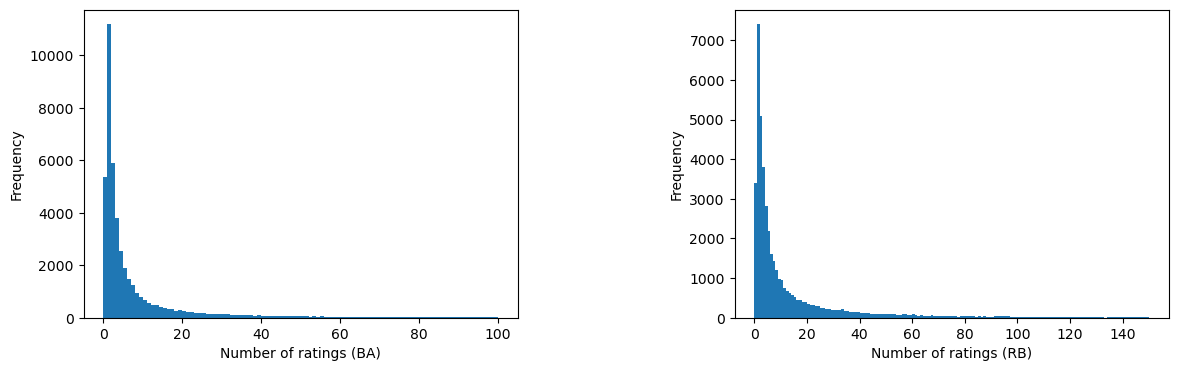

In [12]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False, gridspec_kw={'width_ratios':[1,1], 'wspace': 0.5})

time_MB_beers['nbr_ratings_BA'].sort_values().plot(kind='hist', range = (0, 100), bins= 100, ax=axs[0])
axs[0].set_xlabel('Number of ratings (BA)')
time_MB_beers['nbr_ratings_RB'].sort_values().plot(kind='hist', range = (0, 150), bins= 150, ax=axs[1])
axs[1].set_xlabel('Number of ratings (RB)')

In [13]:
time_MB_beers.nbr_ratings_BA.describe()

count    45640.000000
mean        20.945837
std        137.768038
min          0.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       9228.000000
Name: nbr_ratings_BA, dtype: float64

In [14]:
time_MB_beers.nbr_ratings_RB.describe()

count    45640.000000
mean        22.362796
std         80.107455
min          0.000000
25%          2.000000
50%          5.000000
75%         16.000000
max       5272.000000
Name: nbr_ratings_RB, dtype: float64

Seeing this basic statistics and having observed the histograms we will filter out so that we keep beers with at least 5 ratings for both of the datasets (columns 'nbr_ratings_BA' and 'nbr_ratings_RB'). This will later help us in dimishing the **herding effect** and in assessing popularity by having a consistently high score (and not a high score once).

Fig. 6 in the previously mentioned paper, shows that the herding effect, although never converging to 0, becomes stable with a larger number of ratings with respect to the first one. Thus, we will keep the beers with at least 5 ratings. Note that 5 is the median value of the number of ratings in RateBeer but, in the case of BearAdvocate, it is below it. However, discarding these samples still leaves us with approximately 30% of the data which is a large amount of data (12890 beers).

In [15]:
time_filt_MB_beers = time_MB_beers[(time_MB_beers['nbr_ratings_BA'] >= 5) & (time_MB_beers['nbr_ratings_RB'] >= 5)].copy(deep=True) 

### Macro-averages

In [16]:
# Based on the keep beers (with more than 5 ratings in each source), we will select all the available ratings
beer_id_BA = time_filt_MB_beers.beer_id_BA.to_numpy()
beer_id_RB = time_filt_MB_beers.beer_id_RB.to_numpy()

time_ratings_BA = MB_ratings_BA[MB_ratings_BA['beer_id'].isin(beer_id_BA)].copy(deep=True)
time_ratings_RB = MB_ratings_RB[MB_ratings_RB['beer_id'].isin(beer_id_RB)].copy(deep=True)

In [17]:
# Mean for each beer in each year
avgBA = time_ratings_BA.groupby(['year', 'beer_id'])['detrend'].mean()
avgRB = time_ratings_RB.groupby(['year', 'beer_id'])['detrend'].mean()

In [19]:
# Creation of a dataframe with the results (this also implies matching in the beer ID which is NOT the same for BA and RB)
avgBA_df = avgBA.reset_index()
avgBA_df = avgBA_df.rename(columns={'detrend': 'detrend_BA', 'beer_id': 'beer_id_BA'})
avgRB_df = avgRB.reset_index()
avgRB_df = avgRB_df.rename(columns={'detrend': 'detrend_RB', 'beer_id': 'beer_id_RB'})

matching_RB_id = []
for number in avgBA_df['beer_id_BA']:
    matching_RB_id.append(time_filt_MB_beers.beer_id_RB[time_filt_MB_beers['beer_id_BA']== number].to_numpy()[0])
       
avgBA_df['beer_id_RB'] = matching_RB_id

In [20]:
macro = avgBA_df.merge(avgRB_df, on=['beer_id_RB', 'year'], how='outer')
macro = macro.drop('beer_id_BA', axis=1)

macro['average'] = macro[['detrend_BA', 'detrend_RB']].mean(axis=1)

In [22]:
macro

,year,detrend_BA,beer_id_RB,detrend_RB,average
0,1998,0.574938,966,NaN,0.574938
1,1998,-0.882523,529,NaN,-0.882523
2,1998,-0.994041,528,NaN,-0.994041
3,1998,-0.834351,8735,NaN,-0.834351
4,1998,-0.224596,8330,NaN,-0.224596
...,...,...,...,...,...
67255,2017,NaN,460124,0.386939,0.386939
67256,2017,NaN,460203,-1.584041,-1.584041
67257,2017,NaN,461933,-0.071984,-0.071984
67258,2017,NaN,462240,-0.192898,-0.192898


### Top beer each year

In [23]:
result = macro.loc[macro.groupby('year')['average'].idxmax()]

In [24]:
result

,year,detrend_BA,beer_id_RB,detrend_RB,average
0,1998,0.574938,966,NaN,0.574938
6,1999,-0.165385,2094,NaN,-0.165385
53817,2000,NaN,6075,1.441052,1.441052
53961,2001,NaN,5941,1.695255,1.695255
54431,2002,NaN,16520,1.716757,1.716757
888,2003,1.724326,22663,NaN,1.724326
55241,2004,NaN,25325,1.733733,1.733733
55806,2005,NaN,32190,2.338038,2.338038
56203,2006,NaN,15127,1.787023,1.787023
57395,2007,NaN,82103,2.020311,2.020311


# Geographical analysis

In [9]:
# Copy the dataframe to avoid modiying the variable for further analysis
geo_MB_ratings = MB_ratings.copy(deep=True)


In [10]:
geo_MB_ratings = hf.correct_time(geo_MB_ratings)
columns_to_keep = ['user_id', 'rating','year', 'beer_name','user_id.1']
geo_filter_MB_ratings = geo_MB_ratings.filter(columns_to_keep)

In [11]:
geo_filter_MB_ratings.shape

(21964, 5)

So with the previous datasets we have the geographical location and the brewery name. Furthermore, it can be merged by the userID that coincides in both columns. Since for there are two different user ids (one for each dataset), we will do the merging in just one of them. In our case, we used BA id for the merging.

In [12]:
geo_beers = pd.merge(geo_filter_MB_ratings, MB_users[['user_id','location']], on='user_id', how='inner')

In this way we populate the ratings dataset with the location of each user which provides us a relation between a place and parameters related to the beer.

In [13]:
geo_beers

,user_id,rating,year,beer_name,user_id.1,location
0,erzengel.248045,4.80,2011,Trappistes Rochefort 10,83106,Germany
1,visionthing.639993,3.00,2011,Myanmar Lager Beer,91324,Estonia
2,tiong.608427,3.85,2012,Cantillon Tyrnilambic Baie D’Argousier Lambic,98624,Finland
3,tiong.608427,3.68,2012,Cantillon Pikkulinnun Viskilambic,98624,Finland
4,tiong.608427,4.00,2012,Drie Fonteinen Oude Geuze - Armand & Tommy,98624,Finland
...,...,...,...,...,...,...
21959,thebeerwatcher.630107,3.91,2011,Valeir Divers,137922,Belgium
21960,jonj.982265,4.08,2017,Fantôme Saison,394232,Faroe Islands
21961,maxilouis.784601,3.00,2014,Jupiler,304802,Belgium
21962,simoen.728327,2.88,2014,Redenaar,276666,Belgium


In [14]:
location_count = geo_beers.groupby('user_id.1', as_index=False).location.nunique()
nationality_check = location_count.sort_values('location', ascending=False)
nationality_check

,user_id.1,location
878,480444,1
0,46,1
1,154,1
2,180,1
3,181,1
...,...,...
18,5332,1
19,5348,1
20,5448,1
21,5464,1


In [15]:
count_locations = geo_beers.groupby('location', as_index=False).user_id.count()

In [16]:
popular_locations = count_locations.sort_values(by='user_id', ascending=False)
most_popular_locations = popular_locations[popular_locations.user_id >= 20]

In [17]:
locat_list = most_popular_locations['location'].tolist()

In [18]:
filtered_geo_beers = geo_beers[geo_beers['location'].isin(locat_list)]

In [19]:
filtered_geo_beers

,user_id,rating,year,beer_name,user_id.1,location
0,erzengel.248045,4.80,2011,Trappistes Rochefort 10,83106,Germany
7,leighton.343447,4.35,2015,Lindemans Oude Gueuze Cuvée René Special Blend...,74136,England
8,leighton.343447,4.75,2013,Ann,74136,England
9,leighton.343447,4.00,2016,Mornin' Delight,74136,England
10,leighton.343447,4.75,2016,Beavertown / Boneyard Bloody Notorious,74136,England
...,...,...,...,...,...,...
21958,thebeerwatcher.630107,3.92,2011,Vapeur Cochonne,137922,Belgium
21959,thebeerwatcher.630107,3.91,2011,Valeir Divers,137922,Belgium
21961,maxilouis.784601,3.00,2014,Jupiler,304802,Belgium
21962,simoen.728327,2.88,2014,Redenaar,276666,Belgium


In [20]:
def unify_location(loc, keep_state=False):
    if not keep_state:
        return 'United States' if loc.startswith('United States') else loc
    else: 
        if loc.startswith('United States'):
            return loc.split(',')[1]
        else: 
            return loc


In [21]:
filtered_geo_beers['Location'] = filtered_geo_beers.location.apply(unify_location)

/tmp/ipykernel_598/422876615.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_geo_beers['Location'] = filtered_geo_beers.location.apply(unify_location)


In [22]:
filtered_geo_beers['location'] = filtered_geo_beers.location.apply(unify_location, keep_state=True)

/tmp/ipykernel_598/2567024652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_geo_beers['location'] = filtered_geo_beers.location.apply(unify_location, keep_state=True)


In [23]:
#by original location:
count_state_pop = filtered_geo_beers.groupby('location', as_index=False)['user_id.1'].sum()
count_state_pop_order = count_state_pop.sort_values(by='user_id.1',ascending= True)
display(count_state_pop_order)

#by country:
count_country_pop = filtered_geo_beers.groupby('Location', as_index=False)['user_id.1'].sum()
count_country_pop_order = count_country_pop.sort_values(by='user_id.1',ascending= True)
count_country_pop_order

,location,user_id.1
20,Nebraska,648286
53,Thailand,868834
18,Mississippi,1414299
19,Missouri,2028897
49,Scotland,2662505
37,Wyoming,3163596
34,Virginia,3521656
29,Rhode Island,3523595
33,Vermont,3615947
26,Oklahoma,3750116


,Location,user_id.1
15,Thailand,868834
11,Scotland,2662505
12,Slovenia,4913192
1,Belarus,5864320
2,Belgium,6185612
0,Australia,6592988
10,Russia,10405150
7,Netherlands,22283501
14,Sweden,36963072
3,Brazil,36991517


Text(0.5, 0, 'Number of users (hundreds of millions)')

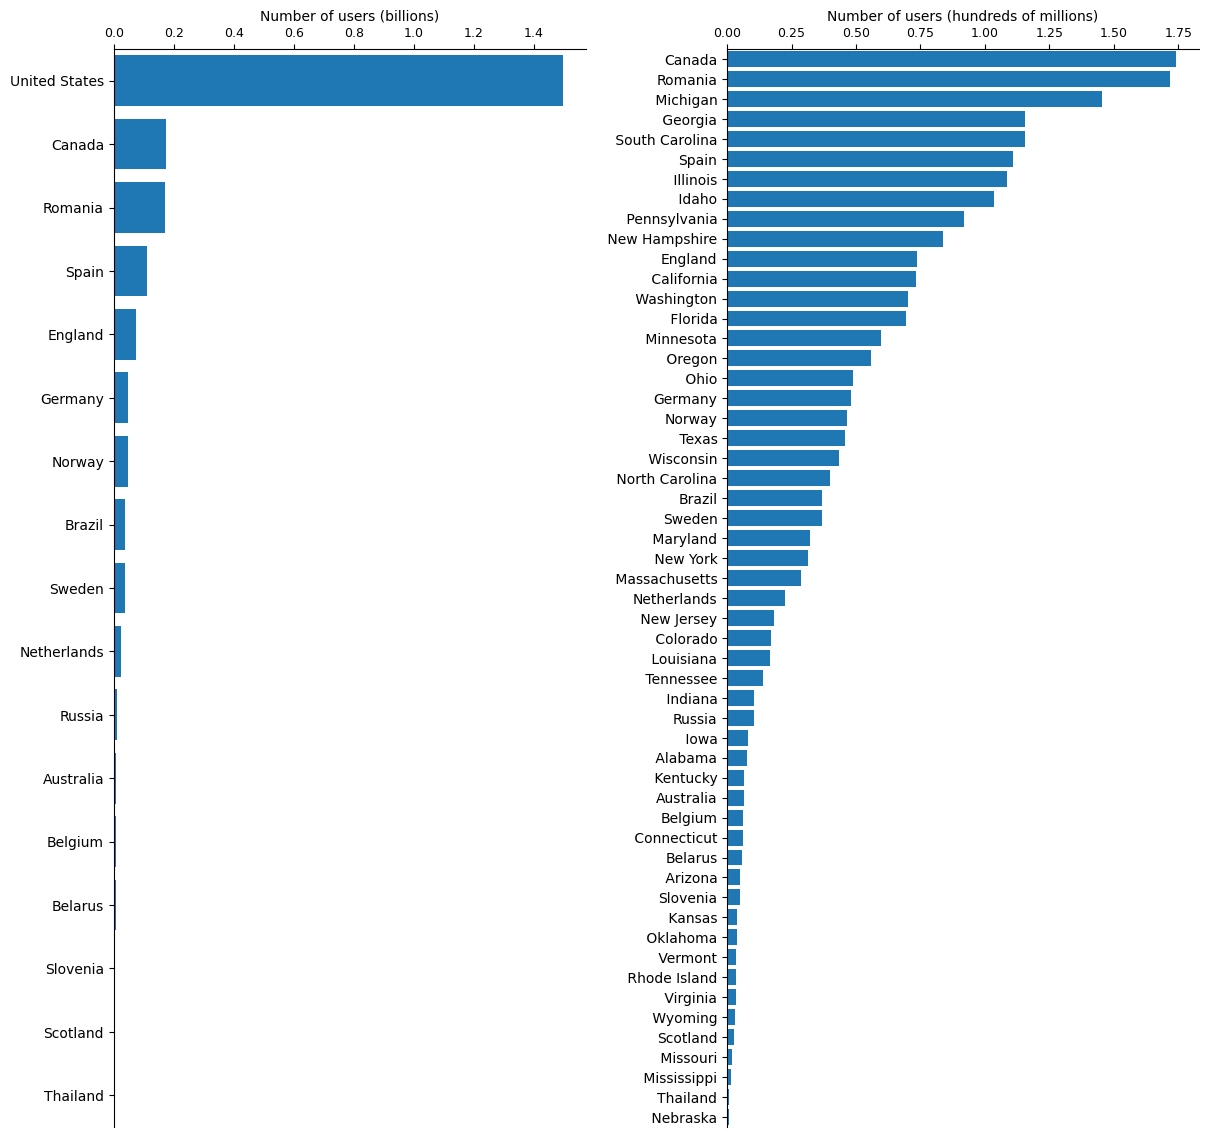

In [24]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(14,14), sharey=False, gridspec_kw={'wspace': 0.3})

axs[0].barh(count_country_pop_order.Location, count_country_pop_order['user_id.1'])
axs[1].barh(count_state_pop_order.location, count_state_pop_order['user_id.1'])
axs[0].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[1].tick_params(axis = 'x', labelsize= 9, bottom=False, labelbottom=False, top=True, labeltop=True)
axs[0].xaxis.set_label_position('top')
axs[1].xaxis.set_label_position('top')
axs[0].xaxis.offsetText.set_visible(False)
axs[1].xaxis.offsetText.set_visible(False)


axs[0].spines['bottom'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['right'].set_visible(False)

axs[0].set_ylim(-0.5,len(count_country_pop_order.Location)-0.5)
axs[1].set_ylim(-0.5,len(count_state_pop_order.location)-0.5)
axs[0].set_xlabel('Number of users (billions)')
axs[1].set_xlabel('Number of users (hundreds of millions)')

# Matching users by styles ratings 

As we are focusing on the preferences on the style of beers, we consider that the user that did a review in the two different websites, these are different users

In [ ]:
#Merge RB and BA ratings
total_MB_ratings = pd.concat([MB_ratings_BA, MB_ratings_RB])
total_MB_ratings.shape

In [ ]:
#Here we will see how is the distribution of the different beers

value_counts = total_MB_ratings['style'].value_counts()

fig, ax = plt.subplots( figsize = (8,10))
ax.barh(value_counts.index, value_counts)

# Set labels and title
ax.set_xlabel('Matched reviews')
ax.set_ylabel('Style')
ax.set_title('Style vs Matched reviews ')
ax.tick_params(axis = 'x', labelsize = 10)
ax.tick_params(axis = 'y', labelsize = 5)

# Rotate the entire plot by 90 degrees
plt.gca().invert_yaxis()  # Invert y-axis to make the plot more readable
plt.show()

In [ ]:
value_counts[0:10]
#We can see that just in the top 10, there are multiple styles of IPA and Pale Ale that could be somehow grouped

In [ ]:
style_pref_merged = pd.crosstab(total_MB_ratings['user_id'].values, total_MB_ratings['style'].values, 
                                values = total_MB_ratings['detrend'].values, aggfunc='mean')

style_pref_merged = style_pref_merged.T.fillna(0)

In [ ]:
from scipy.stats import pearsonr

#pearson_matrix = style_pref_merged.corr(numeric_only= True)

Pearson_matrix will give a matrix of size 92113x92113 which is too big, and therefore is computationally complex. For tackling this problem
We thougth on calculating the pearson coefficient per column pairwise and then just keep the maximum value after a defined threshold.

Another idea is to find a better classifier for the styles, either by grouping manually by the type independent of the country and
 subtypes of the style or to apply a ML algorithm for an optimized clustering